## Оценка качества модели

Рассмотрим результаты, полученные с помощью разработанной модели, с точки зрения других метрик (кроме Accuracy), которые также могут быть важны для бизнеса.

In [31]:
import sys
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)
print('Sklearn      :', sklearn.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Pandas       : 1.2.3
Sklearn      : 0.24.1


In [6]:
np.random.seed(0)

In [7]:
!pip freeze > requirements.txt

In [8]:
DATA_DIR = '../input/findata-creditscoring/'
train = pd.read_csv(DATA_DIR + 'credit_train.csv')
test = pd.read_csv(DATA_DIR + 'credit_test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'credit__sample.csv')
train.drop_duplicates(keep='first', inplace = True)
train['Loan Status'] = train['Loan Status'].map({"Fully Paid": 1, "Charged Off": 0})
train.drop(['Loan ID','Customer ID',], axis = 1, inplace=True)
test.drop(['Loan ID','Customer ID',], axis = 1, inplace=True)

In [9]:
X = train.drop(['Loan Status'], axis=1)
y = train['Loan Status'].values  

Обучим модель, предварительно разбив исходный датасет на тренировочную и валидационную выборки. 

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [12]:
categorical_values = []

cat_subset = X_train.select_dtypes(include = ['object','category','bool'])

for i in range(cat_subset.shape[1]):
    categorical_values.append(list(cat_subset.iloc[:,i].dropna().unique()))
        
num_pipeline = Pipeline([
            ('cleaner',SimpleImputer(strategy = 'median'))
            ])

cat_pipeline = Pipeline([
            ('cleaner',SimpleImputer(strategy = 'most_frequent')),
            ('encoder',OneHotEncoder(sparse = False, categories=categorical_values))
            ])

preprocessor = ColumnTransformer([
            ('numerical', num_pipeline, make_column_selector(dtype_exclude=['object','category','bool'])),
            ('categorical', cat_pipeline, make_column_selector(dtype_include=['object','category','bool']))
            ])
            
model_pipeline_steps = []
model_pipeline_steps.append(('preprocessor',preprocessor))
model_pipeline_steps.append(('feature_selector',SelectKBest(f_classif, k= 41)))
model_pipeline_steps.append(('estimator', RandomForestClassifier(
                             n_estimators = 275, 
                             random_state = 0,
                             criterion = 'gini')))
    
model_pipeline = Pipeline(model_pipeline_steps)

In [14]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('cleaner',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3906504a90>),
                                                 ('categorical',
                                                  Pipeline(steps=[('cleaner',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[['Long '
                                                                                              '...
                                                       

Оценим различные метрики, полученные в результате предсказаний модели на валидационной выборке. 

In [15]:
y_val_pred = model_pipeline.predict(X_val)

#### F1-мера

In [16]:
f_1_val = f1_score(y_val, y_val_pred)
print('F-мера:',  f_1_val)

F-мера: 0.8804008760868121


#### Матрица ошибок

In [28]:
cm = confusion_matrix(y_val, y_val_pred)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

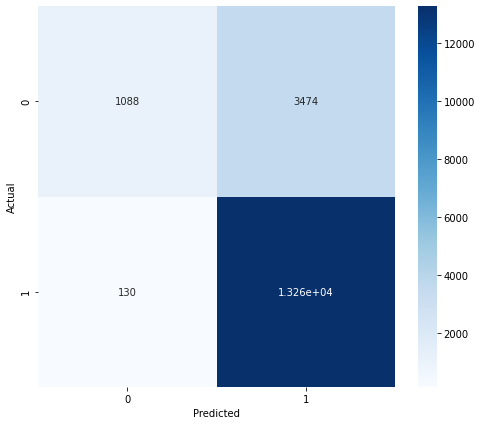

In [35]:
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='.4g')

In [29]:
TN, FP, FN, TP = cm.ravel()

Sp = TN/(TN+FP)
typeI = FP/(FP+TN)
typeII = FN/(FN+TP)

print('Accuracy: ', accuracy_score(y_val,y_val_pred))
print('Sensitivity: ', recall_score(y_val,y_val_pred))
print('Specificity: ', Sp)
print('Precision: ', precision_score(y_val, y_val_pred))
print('Type I error rate: ', typeI)
print('Type II error rate: ', typeII)

Accuracy:  0.7992983237734588
Sensitivity:  0.990294886151549
Specificity:  0.2384918895221394
Precision:  0.7924607204731465
Type I error rate:  0.7615081104778606
Type II error rate:  0.009705113848450915


#### Кривая ошибок

In [20]:
y_pred_val_proba = model_pipeline.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_proba)
roc_auc = roc_auc_score(y_val, y_pred_val_proba)

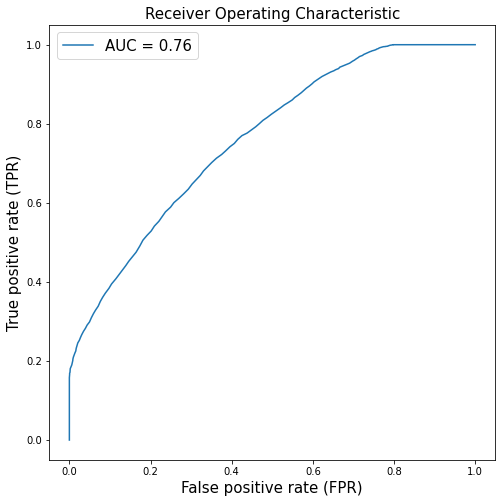

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

### Выводы

Оценены метрики качества модели, которые, наряду с Accuracy, также имеют значение для бизнеса:
- F1-мера - 0.88
- Recall - 0.99
- Specificity:  0.24
- Precision:  0.79
- Ошибка I рода:  0.76
- Ошибка II рода:  0.0097